| **Chapter**                   | 8:  Spatial dynamics of epidemics                                                      |
| ----------------------------- |----------------------------------------------------------------------------------------|
| **Computational Note**        | 8.8: Hospital access                                                                   |
| **Package prerequisites**     | [osmnx](https://osmnx.readthedocs.io/en/stable/), [igraph](https://igraph.org/python/) |


# Hospital accessibility in Oxford, England

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import osmnx
import networkx as nx
import random
import igraph as ig
import numpy as np
import matplotlib.ticker as ticker

SMALL_SIZE = 5
matplotlib.rc("font", size=SMALL_SIZE)
matplotlib.rc("axes", titlesize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

numpy     : 1.21.6
igraph    : 0.9.9
osmnx     : 1.2.0
matplotlib: 3.5.2
networkx  : 2.8.4



In [3]:
location = "Oxford, England"
crs = 27700

In [4]:
%%time

graph = osmnx.graph_from_place(location, network_type="drive")

CPU times: user 4.21 s, sys: 93.5 ms, total: 4.3 s
Wall time: 4.35 s


In [5]:
graph = osmnx.distance.add_edge_lengths(graph)

In [6]:
osm_ids = list(graph.nodes)
graph = nx.relabel.convert_node_labels_to_integers(graph)

osm_id_vals = {k: v for k, v in zip(graph.nodes, osm_ids)}
nx.set_node_attributes(graph, osm_id_vals, "osmid")

In [7]:
i_graph = ig.Graph(directed=True)
i_graph.add_vertices(graph.nodes)
i_graph.add_edges(graph.edges())
i_graph.vs["osmid"] = osm_ids
i_graph.es["length"] = list(nx.get_edge_attributes(graph, "length").values())

In [8]:
nodes, edges = osmnx.graph_to_gdfs(graph)
nodes.geometry = nodes.geometry.to_crs(crs)
edges.geometry = edges.geometry.to_crs(crs)

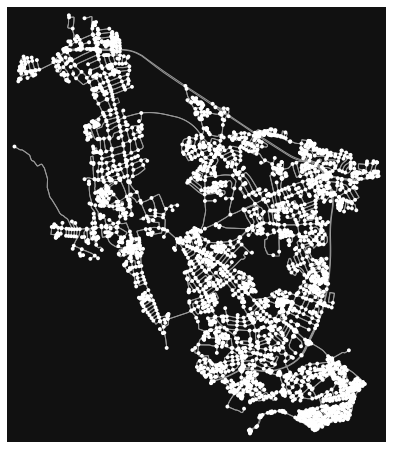

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
osmnx.plot_graph(graph)

In [10]:
%%time

hospitals = osmnx.geometries.geometries_from_place(location, tags={"amenity": ["hospital"]})[["geometry"]]
hospitals.geometry = hospitals.geometry.to_crs(crs)

CPU times: user 112 ms, sys: 8.05 ms, total: 120 ms
Wall time: 110 ms


/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


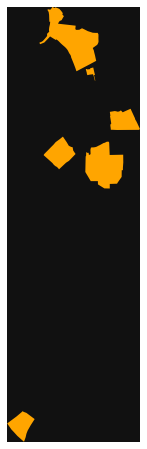

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [11]:
osmnx.plot_footprints(hospitals)

In [12]:
%%time

residential = osmnx.geometries.geometries_from_place(location, tags={"building": ["house", "apartments", "residential", "detached", "terrace"]})[["geometry"]].sort_index()
residential.geometry = residential.geometry.to_crs(crs)

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


CPU times: user 2.46 s, sys: 136 ms, total: 2.6 s
Wall time: 2.34 s


/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


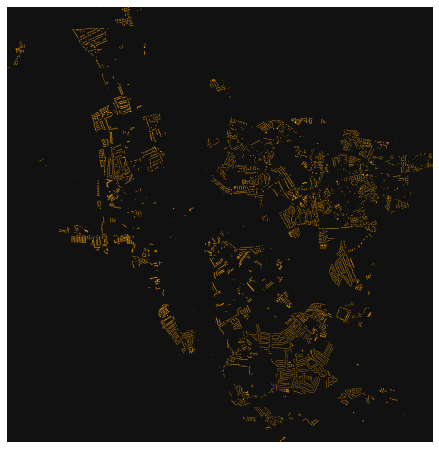

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [13]:
osmnx.plot_footprints(residential)

In [14]:
pgraph = osmnx.project_graph(graph, crs)
hospitals["nearest_node"] = osmnx.distance.nearest_nodes(pgraph, hospitals.geometry.centroid.x, hospitals.geometry.centroid.y)
residential["nearest_node"] = osmnx.distance.nearest_nodes(pgraph, residential.geometry.centroid.x, residential.geometry.centroid.y)

In [15]:
def get_distance_to_nearest_hospital(source_node) -> float:
    distances = []
    for hospital_node in hospitals.nearest_node:
        path = i_graph.get_shortest_paths(source_node, hospital_node, weights="length", output="epath")[0]
        path_length = sum(list(map(lambda x: i_graph.es[x]["length"], path)))
        distances.append(path_length)
    return min(distances)

In [16]:
%%time

residential = residential[residential.geometry.apply(lambda x: x.type != "Point")]
residential["distance_to_nearest_hospital"] = residential.nearest_node.apply(get_distance_to_nearest_hospital)

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_60202/3242123467.py:4: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  path = i_graph.get_shortest_paths(source_node, hospital_node, weights="length", output="epath")[0]


CPU times: user 59.9 s, sys: 801 ms, total: 1min
Wall time: 1min 1s


/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarnin

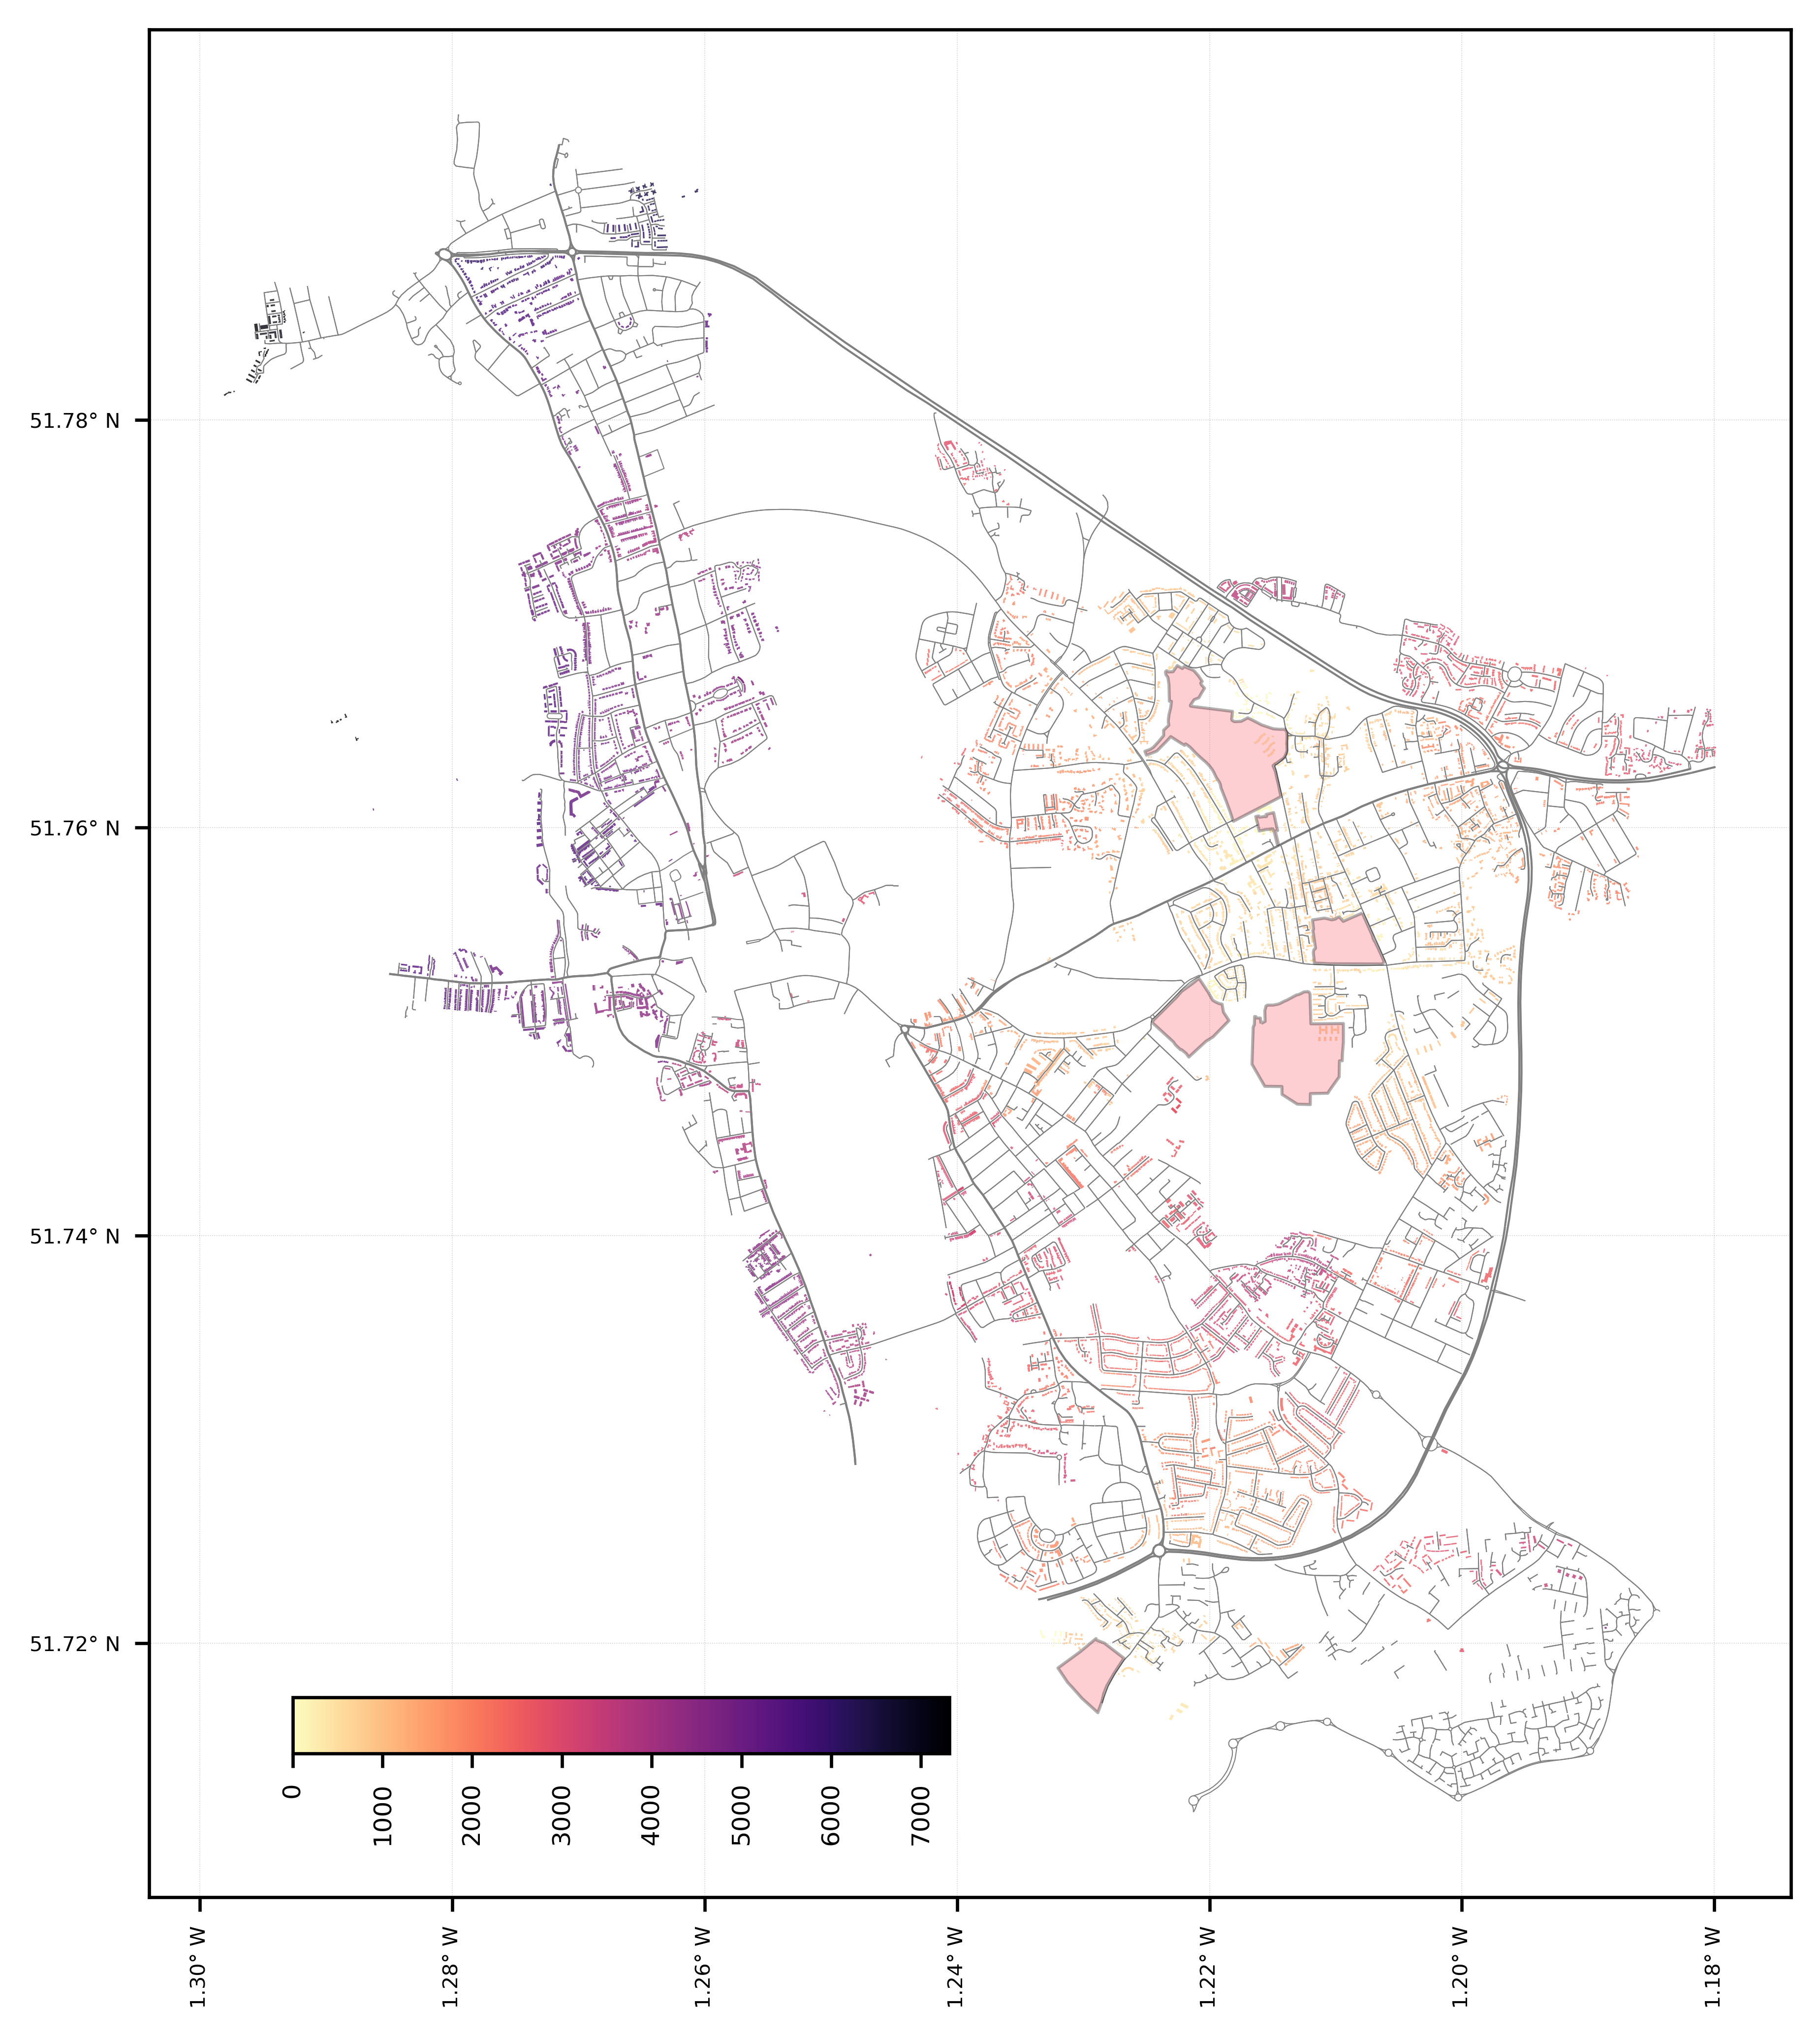

In [21]:
fig = plt.figure(facecolor="w", figsize=(7, 7), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

colourmap = "magma_r"

edges.geometry = edges.geometry.to_crs(4326)
hospitals.geometry = hospitals.geometry.to_crs(4326)
residential.geometry = residential.geometry.to_crs(4326)

arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]
secondary_roads = edges.loc[edges.highway.isin(["secondary", "tertiary", "residential"])]

arterial_roads.plot(ax=ax, lw=0.5, color='gray', zorder=3)
secondary_roads.plot(ax=ax, lw=0.25, color='gray', zorder=3)
hospitals.plot(ax=ax, facecolor=COLORS["I"], linewidth=0.75, edgecolor="k", zorder=4, alpha=0.3)
residential.plot("distance_to_nearest_hospital", cmap=colourmap, alpha=0.8, zorder=2, ax=ax)

ax.tick_params(axis="x", labelsize=5, rotation=90, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.tick_params(axis="y", labelsize=5, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° W"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° N"))
ax.grid()


norm = colors.Normalize(vmin=residential.distance_to_nearest_hospital.min(), vmax=residential.distance_to_nearest_hospital.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap=colourmap)

fig.tight_layout()

axins = inset_axes(ax, width="40%", height="3%", loc="lower left", borderpad=7)
axins.tick_params(axis="x", labelsize=6, rotation=90)

ax_cbar = fig.colorbar(cbar, cax=axins, orientation="horizontal")

plt.savefig("hospital_isodistance.pdf")